## Segmentação de Imagens

- Dataset: Pascal VOC 2012
- Modelo: DeepLab ResNet-50


`Thiago Gustavo Vieira de Paiva`
<br>[github.com/tgvp](https://github.com/tgvp)

##### DeepLabv3+
Realiza a atribuição de rótulos de classe a cada pixel de uma imagem.
A principal contribuição do DeepLabv3+ é a adoção de uma abordagem de pós-processamento chamada `Atrous Spatial Pyramid Pooling (ASPP)`, que permite capturar informações contextuais em diferentes escalas.

Convoluções com taxa de dilatação: operação de convolução que permite aumentar o campo receptivo de uma camada convolucional sem aumentar significativamente o número de parâmetros ou o custo computacional.

![](../img/deeplab.png)

##### ResNet-50
- Conexões de atalho, também conhecidas como conexões residuais, que permitem que as informações fluam diretamente através das camadas da rede.

- Evita degradação de desempenho

![](../img/skip_connectors.png)

![](../img/space_increase.png)


## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torchvision.models.segmentation import deeplabv3_resnet50

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

## Paths
- `train_dir` : directory for the training set
- `val_dir` : directory for the validation set
- `test_dir` : directory for the test set

## Training for 10 epochs

In [95]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet50

# Paths
dataset_dir = "../data/pascal_voc_dataset/VOCdevkit/VOC2012/JPEGImages"
train_dir = "../data/pascal_voc_dataset/train"
val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"
mask_dir = "../data/pascal_voc_dataset/VOCdevkit/VOC2012/mask"

# Transforms to input images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

""" ImageNet dataset.
Subtracting the mean values from each pixel of the image
centers the distribution of pixel values around zero.

Scaling the data: Dividing the pixel values by the standard deviation values
scales down the range of pixel values.
It ensures that the input data falls within a reasonable range,
which can improve the stability and convergence of the training process.
"""

# Transformations for the masks
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Download and load the PASCAL VOC dataset
train_set = VOCSegmentation(root=train_dir, year='2012', image_set='train', download=True, transform=transform, target_transform=mask_transform)
val_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = val_set

# Split dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

model = deeplabv3_resnet50()

model.train()

# loss function
""" CE = -sum(y_true * log(y_pred))
Compara a distribuição de probabilidade prevista pelo modelo
com a distribuição verdadeira dos rótulos de classe.

o objetivo é fazer com que a distribuição prevista pelo modelo se aproxime
o máximo possível da distribuição verdadeira dos rótulos de classe.
"""
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        
        # zera os gradientes
        optimizer.zero_grad()

        outputs = model(images)['out']

        # calcula a perda
        loss = criterion(outputs, masks.squeeze(1).long())

        # calcula os gradientes em relação à função de perda e passa através do modelo
        loss.backward()
        
        # os gradientes são calculados em relação à função de perda e parâmetros do modelo são atualizados
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")


torch.save(model.state_dict(), "modelo_treinado_{num_epochs}.pth")

Using downloaded and verified file: ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/train
Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


/opt/anaconda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /home/tg/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

Epoch [1/10], Loss: 0.24918922781944275
Epoch [2/10], Loss: 0.20213866421108037
Epoch [3/10], Loss: 0.19253508082993043
Epoch [4/10], Loss: 0.19026672070632217
Epoch [5/10], Loss: 0.1877308344173301
Epoch [6/10], Loss: 0.18433189445017464
Epoch [7/10], Loss: 0.18598272394938548
Epoch [8/10], Loss: 0.18361554193040713
Epoch [9/10], Loss: 0.18338388794921134
Epoch [10/10], Loss: 0.18133230568444142


Saving the model for 10 epochs

In [97]:
torch.save(model.state_dict(), "../data/modelo_10.pth")

Loading saved model

In [21]:
import torch
import torchvision

model = torchvision.models.segmentation.deeplabv3_resnet50(weights=True)

model.load_state_dict(torch.load('trained_model.pth'))

model.eval()

/opt/anaconda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

- `backbone`: O backbone é responsável por extrair características da imagem e consiste em uma série de camadas convolucionais e de pooling. Neste caso, o módulo IntermediateLayerGetter retorna camadas intermediárias do backbone para uso posterior.

- `conv1`: É a primeira camada convolucional do backbone, que recebe a imagem de entrada. Essa camada usa um **filtro convolucional 7x7** com **stride 2** para reduzir a resolução da imagem.

        - deslocando o filtro em uma taxa de stride de 2 pixels.

- `bn1`: É a camada de normalização por batch após a primeira camada convolucional.

- `relu`: É a função de ativação ReLU, aplicada após a normalização por batch.
        
        - retorna o valor de entrada se for maior que zero e retorna zero caso contrário.

- `maxpool`: É a camada de pooling máximo, que reduz a resolução espacial da imagem pela metade.
        
        - pooling: reduz a resolução espacial da imagem, reduzindo o número de parâmetros e o custo computacional. Isso é feito através da divisão da imagem em regiões sobrepostas e, em seguida, aplicando uma função de agregação em cada região para obter um único valor representativo.

- `layer1`: É a primeira sequência de blocos residuais, que são blocos convolucionais que utilizam conexões residuais para contornar o problema de degradação do desempenho em redes profundas.

- `Bottleneck`: É o bloco residual utilizado na ResNet, composto por várias camadas convolucionais e de normalização.

- `conv1`, `bn1`, `conv2`, `bn2`, `conv3`, `bn3`: São camadas convolucionais e de normalização utilizadas dentro do bloco residual.

- `downsample`: É uma sequência de camadas convolucionais e de normalização que é usada para ajustar a dimensão das ativações residuais antes de adicioná-las às ativações do bloco residual.

#### Setting `Test Loader`

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm import tqdm

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = Subset(test_set, range(1100))

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)

In [5]:
torch.cuda.is_available(), torch.cuda.device_count()

(False, 0)

In [5]:
import multiprocessing
from torch.utils.data import DataLoader

model = deeplabv3_resnet50(weight=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_cpu = multiprocessing.cpu_count()

print(f"Device: {device}")
print(f"CPU cores: {num_cpu}")

model = model.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")

Device: cpu
CPU cores: 8
Using 8 CPU cores.


In [11]:
for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
    with torch.no_grad():
        outputs = model(images)
    
    # Save each prediction as separate files using torch.save()
    torch.save(images, f'../rsc/test/image_{i}.pth')
    torch.save(outputs['out'], f'../rsc/test/output_{i}.pth')
    torch.save(masks, f'../rsc/test/mask_{i}.pth')

100%|██████████| 1100/1100 [16:41<00:00,  1.10it/s]


In [23]:
from tqdm import tqdm

predictions = []

for images, masks in tqdm(test_loader):
    with torch.no_grad():
        outputs = model(images)
        
    predictions.append((outputs, masks))

100%|██████████| 1100/1100 [08:47<00:00,  2.09it/s]


In [16]:
index = 350
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/test/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

(torch.Size([1, 3, 256, 256]),
 torch.Size([1, 21, 256, 256]),
 torch.Size([1, 1, 256, 256]))

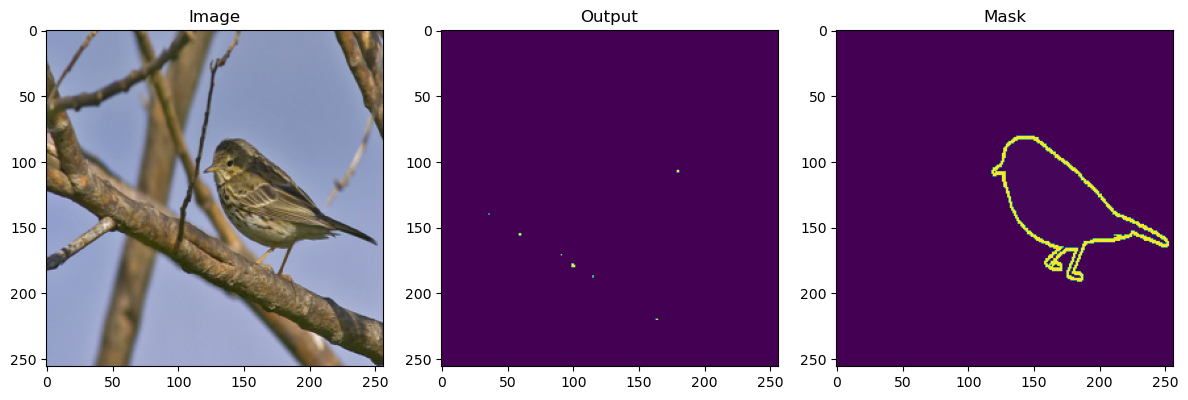

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load and visualize the saved images, outputs, and masks for a specific index
index = 350

# Load the image, output, and mask tensors
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/test/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

# Convert the image, output, and mask tensors to NumPy arrays
image_np = image.squeeze().permute(1, 2, 0).numpy()
output_np = output.squeeze().argmax(dim=0).numpy()
mask_np = mask.squeeze().numpy()

# Plot the image, output, and mask
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(image_np)
axs[0].set_title('Image')
axs[1].imshow(output_np)
axs[1].set_title('Output')
axs[2].imshow(mask_np)
axs[2].set_title('Mask')

plt.tight_layout()
plt.show()

#### Similarity by `Intersection of Union (IoU)` function a.k.a the `Jaccard Index`

- measures the overlap between the predicted segmentation and the ground truth segmentation.

- calculated by dividing the intersection of the predicted and ground truth regions by their union.

- `IoU = (|X & Y|) / (|X| + |Y| - |X & Y|)`

- `higher IoU score` indicates a better segmentation result, where a score of 1 represents a perfect overlap between the predicted and ground truth segmentations. Conversely, a `lower score` indicates poor alignment and less accurate segmentation.

In [60]:
import torch
from tqdm import tqdm

def calculate_iou(outputs, masks):

    # Convert the predicted outputs into a binary mask
    outputs = torch.argmax(outputs, dim=1)
    masks = masks.squeeze()
    
    intersection = torch.logical_and(outputs, masks).sum().item()
    union = torch.logical_or(outputs, masks).sum().item()
    
    iou = intersection / union
    return iou

iou_scores = {}

for i in tqdm(range(1, len(test_loader)+1)):
    
    #images = torch.load(f'../rsc/test/image_{i}.pth')
    outputs = torch.load(f'../rsc/test/output_{i}.pth')
    masks = torch.load(f'../rsc/test/mask_{i}.pth')

    # Calculate IoU score
    iou = calculate_iou(outputs, masks)
    iou_scores[i] = iou

print("\nAverage IoU:", sum(iou_scores.values()) / len(iou_scores))

100%|██████████| 1100/1100 [00:09<00:00, 110.65it/s]


Average IoU: 0.0008590079705382914


### Accuracy and Recall

In [62]:
import torch
from tqdm import tqdm

def calculate_accuracy(outputs, masks):
    predicted = torch.argmax(outputs, dim=1)
    masks = masks.squeeze()
    
    correct_pixels = (predicted == masks).sum().item()
    total_pixels = masks.numel()
    
    accuracy = correct_pixels / total_pixels
    return accuracy

def calculate_recall(outputs, masks):
    true_positive = torch.logical_and(outputs, masks).sum().float()
    false_negative = masks.sum().float() - true_positive

    recall = true_positive / (true_positive + false_negative)
    return recall

accuracy_scores = {}
recall_scores = {}

for i in tqdm(range(1, len(test_loader) + 1)):
    outputs = torch.load(f'../rsc/test/output_{i}.pth')
    masks = torch.load(f'../rsc/test/mask_{i}.pth')

    accuracy = calculate_accuracy(outputs, masks)
    recall = calculate_recall(outputs, masks)

    accuracy_scores[i] = accuracy
    recall_scores[i] = recall.item()

average_accuracy = sum(accuracy_scores.values()) / len(accuracy_scores)
average_recall = sum(recall_scores.values()) / len(recall_scores)

print("\nAverage Accuracy:", average_accuracy)
print("Average Recall:", average_recall)

100%|██████████| 1100/1100 [00:13<00:00, 84.02it/s]


Average Accuracy: 0.6985275407270952
Average Recall: 112.1390621029247


### Training for 40 epochs

In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm import tqdm

In [6]:
train_dir = "../data/pascal_voc_dataset/train"
val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

Transforms to apply to the images

In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Transformations for the masks

In [9]:
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

Download `PASCAL VOC dataset` with image and mask transformations

In [10]:
train_set = VOCSegmentation(root=train_dir, year='2012', image_set='train', download=True, transform=transform, target_transform=mask_transform)
val_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = val_set

Using downloaded and verified file: ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/train
Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


Split into **training**, **validation**, and **test** sets (test set == validation set)

In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

Create an instance of the DeepLab model and set it to train

In [11]:
model = deeplabv3_resnet50(weight=True)
model.train()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Define the loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion, optimizer

Load the model checkpoint

In [14]:
model = deeplabv3_resnet50(weight=True)
state_dict = model.state_dict()

checkpoint = torch.load('trained_model.pth')
avoid = [] #['fc.weight', 'fc.bias']
for key in checkpoint.keys():
    if key in avoid or key not in state_dict.keys():
        continue
    if checkpoint[key].size() != state_dict[key].size():
        continue
    state_dict[key] = checkpoint[key]
model.load_state_dict(state_dict)

<All keys matched successfully>

Train the model for **40 epochs**

In [12]:
import signal

# Define a flag to indicate if the training should stop
stop_training = False

# Define a keyboard interrupt handler
def keyboard_interrupt_handler(signal, frame):
    global stop_training
    print("\nTraining manually stopped. Saving the model...")
    stop_training = True

# Register the keyboard interrupt handler
signal.signal(signal.SIGINT, keyboard_interrupt_handler)

num_epochs = 40

average_loss = []

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    #progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1)
    #for images, masks in train_loader:
    for images, masks in progress_bar:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)['out']

        # Calculate the loss
        loss = criterion(outputs, masks.squeeze(1).long())

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()
        
        if stop_training:
            break

    # Print the average loss for given epoch
    average_loss.append(running_loss / len(train_loader))
    #print(f"Epoch [{epoch}/{num_epochs}], Loss: {average_loss[-1]}")
    
    if stop_training:
        break

print(f"Finished at Epoch: {epoch}")

# Save the trained model
torch.save(model.state_dict(), f"modelo_treinado_{epoch+10}.pth")

Epoch 40/40: 100%|██████████| 92/92 [33:28<00:00, 21.83s/it]

Finished at Epoch: 40


In [39]:
torch.save(model.state_dict(), f"../rsc/modelo_treinado_{epoch+10}.pth")

In [31]:
average_loss_50 = [0.17631141849510049,
 0.1760078303353942,
 0.17567957516597665,
 0.17699727416038513,
 0.17534725862028805,
 0.17581422068178654,
 0.1751396341006393,
 0.17490886742977993,
 0.17501040726252223,
 0.17472864938494953,
 0.17479387508786243,
 0.1744127448486245,
 0.17443648717649604,
 0.17418628688091817,
 0.17493727835624115,
 0.1739431985694429,
 0.1739816817900409,
 0.17584979266900083,
 0.17377908835592476,
 0.17362288839143256,
 0.17392815398457256,
 0.17416580725947153,
 0.17355185844328092,
 0.17338689392351586,
 0.17360149421121762,
 0.17338696697159953,
 0.17370152789289536,
 0.17319321348939254,
 0.1736259548722402,
 0.17264665614651598,
 0.173870211629116,
 0.1731814584168403,
 0.1733411852594303,
 0.17242418990834898,
 0.17254774385820265,
 0.17251144147113615,
 0.17376608442029226,
 0.17219202520082827,
 0.17221781012156737,
 0.17489493265748024]

# TODO: (by TG) dump into json file

In [21]:
sum(average_loss) / len(train_loader)

0.07571765291196468

Loading saved model

In [3]:
import torch
import torchvision

model = torchvision.models.segmentation.deeplabv3_resnet50(weights=True)

model.load_state_dict(torch.load('../rsc/modelo_treinado_50.pth'))

model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

#### Evaluating the model

Test Loader

In [28]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = Subset(test_set, range(1100))

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


In [41]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)

IoU

In [45]:
import torch
from tqdm import tqdm

def calculate_iou(outputs, masks):

    outputs = torch.argmax(outputs, dim=1)
    masks = masks.squeeze()
    
    intersection = torch.logical_and(outputs, masks).sum().item()
    union = torch.logical_or(outputs, masks).sum().item()
    
    iou = intersection / union
    return iou

iou_scores = {}

for i in tqdm(range(1, len(test_loader)+1)):
    
    #images = torch.load(f'../rsc/test/image_{i}.pth')
    outputs = torch.load(f'../rsc/test/output_{i}.pth')
    masks = torch.load(f'../rsc/test/mask_{i}.pth')

    # Calculate IoU score
    iou = calculate_iou(outputs, masks)
    iou_scores[i] = iou

print("\nAverage IoU:", sum(iou_scores.values()) / len(iou_scores))

100%|██████████| 1100/1100 [00:31<00:00, 35.17it/s]


Average IoU: 0.0008590079705382914


Accuracy and Recall

In [ ]:
import torch
from tqdm import tqdm

def calculate_accuracy(outputs, masks):
    predicted = torch.argmax(outputs, dim=1)
    masks = masks.squeeze()
    
    correct_pixels = (predicted == masks).sum().item()
    total_pixels = masks.numel()
    
    accuracy = correct_pixels / total_pixels
    return accuracy

def calculate_recall(outputs, masks):
    true_positive = torch.logical_and(outputs, masks).sum().float()
    false_negative = masks.sum().float() - true_positive

    recall = true_positive / (true_positive + false_negative)
    return recall

accuracy_scores = {}
recall_scores = {}

for i in tqdm(range(1, len(test_loader) + 1)):
    outputs = torch.load(f'../rsc/test/output_{i}.pth')
    masks = torch.load(f'../rsc/test/mask_{i}.pth')

    accuracy = calculate_accuracy(outputs, masks)
    recall = calculate_recall(outputs, masks)

    accuracy_scores[i] = accuracy
    recall_scores[i] = recall.item()

average_accuracy = sum(accuracy_scores.values()) / len(accuracy_scores)
average_recall = sum(recall_scores.values()) / len(recall_scores)

print("\nAverage Accuracy:", average_accuracy)
print("Average Recall:", average_recall)

In [16]:
checkpoint=40
torch.save(model.state_dict(), f"../rsc/modelo_treinado_{checkpoint}.pth")

In [23]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = Subset(test_set, range(1100))

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


In [38]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

In [31]:
images.shape, masks.shape, outputs.shape

(torch.Size([1, 3, 256, 256]),
 torch.Size([1, 1, 256, 256]),
 torch.Size([8, 21, 256, 256]))

## For 40 epochs 

In [39]:
for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
    with torch.no_grad():
        outputs = model(images)
    
    # Save each prediction as separate files using torch.save()
    torch.save(outputs['out'], f'../rsc/test{checkpoint}/output_{i}.pth')

100%|██████████| 138/138 [09:29<00:00,  4.12s/it]


In [1]:
import torch
index = 125 #38, 97, 92, 51
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/test{checkpoint}/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

(torch.Size([1, 3, 256, 256]),
 torch.Size([8, 21, 256, 256]),
 torch.Size([1, 1, 256, 256]))

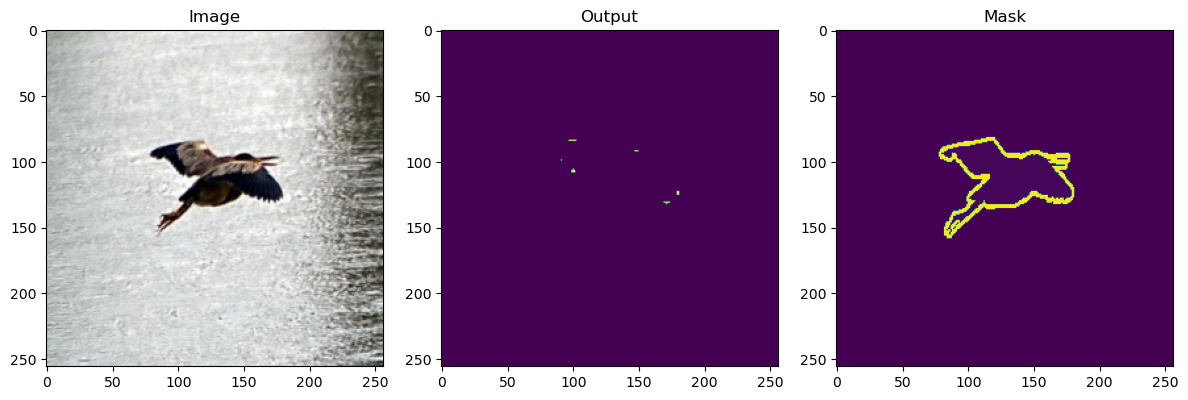

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load and visualize the saved images, outputs, and masks for a specific index
index = 38

# Load the image, output, and mask tensors
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/test/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

# Convert the image, output, and mask tensors to NumPy arrays
image_np = image.squeeze().permute(1, 2, 0).numpy()
output_np = output.squeeze().argmax(dim=0).numpy()
mask_np = mask.squeeze().numpy()

# Plot the image, output, and mask
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(image_np)
axs[0].set_title('Image')
axs[1].imshow(output_np)
axs[1].set_title('Output')
axs[2].imshow(mask_np)
axs[2].set_title('Mask')

plt.tight_layout()
plt.show()

IoU

In [187]:
import torch
from tqdm import tqdm

def calculate_iou(outputs, masks):

    outputs = torch.argmax(outputs, dim=1)
    masks = masks.squeeze()
    
    intersection = torch.logical_and(outputs, masks).sum().item()
    union = torch.logical_or(outputs, masks).sum().item()
    
    iou = intersection / union
    return iou

iou_scores = {}

for i in tqdm(range(1, len(test_loader)+1)):

    outputs = torch.load(f'../rsc/test/output_{i}.pth')
    masks = torch.load(f'../rsc/test/mask_{i}.pth')

    # Calculate IoU score
    iou = calculate_iou(outputs, masks)
    iou_scores[i] = iou

print("\nAverage IoU:", sum(iou_scores.values()) / len(iou_scores))

100%|██████████| 138/138 [00:02<00:00, 51.35it/s]


Average IoU: 0.00042133464513467825


In [54]:
import os
import json

def update_loss_dict(average_loss: list, avgloss_epoch: dict = {}):
    """ Update the loss dictionary with the new loss values and save it into a json file. """
    
    
    if not os.path.exists('../rsc/losses.json'):
        
        for i in range(1, len(avgloss_epoch) - 1):
            avgloss_epoch[i] = average_loss[i - 1]
        
        with open('../rsc/losses.json', 'w') as file:
            json.dump(avgloss_epoch, file)
    else:
    
        with open('../rsc/losses.json', 'r') as file:
            avgloss_epoch = json.load(file)
        
        for i in range(len(avgloss_epoch) + 1, len(avgloss_epoch.keys()) + len(average_loss) + 1):
            avgloss_epoch[i] = average_loss[i-len(avgloss_epoch) - 1]
        
        
        with open('../rsc/losses.json', 'a') as file:
            json.dump(avgloss_epoch, file)
            file.write('\n')
    
    
    
    return avgloss_epoch
    
avgloss_epoch = update_loss_dict(average_loss, avgloss_epoch)
avgloss_epoch

{1: 0.24918922781944275,
 2: 0.20213866421108037,
 3: 0.19253508082993043,
 4: 0.19026672070632217,
 5: 0.1877308344173301,
 6: 0.18433189445017464,
 7: 0.18598272394938548,
 8: 0.18361554193040713,
 9: 0.18338388794921134,
 10: 0.18133230568444142,
 11: 0.178193965733377,
 12: 0.17853890473399658,
 13: 0.17814335047872992,
 14: 0.17924616127554835,
 15: 0.1787690961621498,
 16: 0.17840437680645718,
 17: 0.1781635564125952,
 18: 0.1789794482820021,
 19: 0.1782992491142346,
 20: 0.17862626971279988,
 21: 0.17842466852378325,
 22: 0.17842466852378325,
 23: 0.17842466852378325,
 24: 0.17842466852378325,
 25: 0.17842466852378325,
 26: 0.17842466852378325,
 27: 0.17842466852378325,
 28: 0.17842466852378325,
 29: 0.17842466852378325,
 30: 0.17842466852378325}

In [55]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
# plot avegare loss over epochs
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(avgloss_epoch.keys()), y=list(avgloss_epoch.values()),
                         
                            mode='lines+markers',
                            name='lines+markers'))
fig.update_layout(
    title="Average Loss over Epochs",
    xaxis_title="Epochs",
    yaxis_title="Average Loss")

fig.show()

# Confusion Matrix

In [ ]:
import torch
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix

def calculate_accuracy(outputs, masks):
    predicted = torch.argmax(outputs, dim=1)
    masks = masks.squeeze()
    
    correct_pixels = (predicted == masks).sum().item()
    total_pixels = masks.numel()
    
    accuracy = correct_pixels / total_pixels
    return accuracy

# Initialize the confusion matrix
num_classes = 21
confusion_matrix_total = np.zeros((num_classes, num_classes))

accuracy_scores = {}

for i in tqdm(range(1, len(test_loader) + 1)):
    outputs = torch.load(f'../rsc/test/output_{i}.pth')
    masks = torch.load(f'../rsc/test/mask_{i}.pth')

    accuracy = calculate_accuracy(outputs, masks)
    accuracy_scores[i] = accuracy

    # Convert tensors to np.arrays
    predicted_labels = torch.argmax(outputs, dim=1).flatten().cpu().numpy()
    true_labels = (masks > 0.5).flatten().cpu().numpy()

    # Updatin confusion matrix
    confusion_matrix_total += confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))

average_accuracy = sum(accuracy_scores.values()) / len(accuracy_scores)
print("\nAverage Accuracy:", average_accuracy)

normalized_confusion_matrix = confusion_matrix_total / (confusion_matrix_total.sum(axis=1, keepdims=True) + 1e-8)

fig = go.Figure(data=go.Heatmap(
    z=normalized_confusion_matrix,
    x=list(range(num_classes)),
    y=list(range(num_classes)),
    colorscale='Blues'
))

fig.update_layout(
    title='Confusion Matrix',
    xaxis_title='Predicted Class',
    yaxis_title='True Class',
)

fig.show()

# REST

- `TODO`: (**by TG**) Experimental code that will be `reused/optimized/cleaned` afterwards

### Training 20 epochs

#### Load 20 epochs model

In [12]:
model = deeplabv3_resnet50(weight=True)
state_dict = model.state_dict()

checkpoint = torch.load('modelo_treinado_20.pth')
avoid = [] #['fc.weight', 'fc.bias']
for key in checkpoint.keys():
    if key in avoid or key not in state_dict.keys():
        continue
    if checkpoint[key].size() != state_dict[key].size():
        continue
    state_dict[key] = checkpoint[key]
model.load_state_dict(state_dict)

<All keys matched successfully>

In [83]:
current_checkpoint = 40

#### Training 70 epochs

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

### Optimzing the training for multiprocessor and CUDA support

In [88]:
import multiprocessing
from torch.utils.data import DataLoader

#model = deeplabv3_resnet50(weight=True)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")
    
# Define the loss function
#criterion = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the data loader
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

# Define the number of epochs
num_epochs = 60

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)['out']

        # Calculate the loss
        loss = criterion(outputs, masks.squeeze(1).long())

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")
    #print(f"Epoch [{epoch}/{num_epochs}], Loss: {average_loss[-1]}")

# Save the trained model


Device in use: cuda
Using 1 GPUs.


Epoch 1/60:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 10/60: 100%|██████████| 183/183 [07:51<00:00,  2.58s/it]


Model saved: modelo_50.pth


Epoch 20/60: 100%|██████████| 183/183 [05:36<00:00,  1.84s/it]


Model saved: modelo_60.pth


Epoch 30/60: 100%|██████████| 183/183 [05:39<00:00,  1.86s/it]


Model saved: modelo_70.pth


Epoch 40/60: 100%|██████████| 183/183 [05:14<00:00,  1.72s/it]


Model saved: modelo_80.pth


Epoch 50/60: 100%|██████████| 183/183 [05:37<00:00,  1.84s/it]


Model saved: modelo_90.pth


Epoch 60/60: 100%|██████████| 183/183 [05:49<00:00,  1.91s/it]


Model saved: modelo_100.pth


In [2]:
# creating model from scratch

model = deeplabv3_resnet50(weight=True, batch_size=8)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [3]:
train_dir = "../data/pascal_voc_dataset/train"
val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

# Transforms to input images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transformations for the masks
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Download and load the PASCAL VOC dataset
train_set = VOCSegmentation(root=train_dir, year='2012', image_set='train', download=True, transform=transform, target_transform=mask_transform)
val_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = val_set

Using downloaded and verified file: ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/train
Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


In [15]:
# Split dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

In [17]:
# setting criterion to iou and optimizer to RMSDrop
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [18]:
import multiprocessing
from torch.utils.data import DataLoader

#model = deeplabv3_resnet50(weight=True)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")
    
# Define the loss function
#criterion = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the data loader
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

# Define the number of epochs
num_epochs = 40

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)['out']

        # Calculate the loss
        loss = criterion(outputs, masks.squeeze(1).long())

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")
    #print(f"Epoch [{epoch}/{num_epochs}], Loss: {average_loss[-1]}")

# Save the trained model


Device in use: cuda
Using 1 GPUs.


Epoch 1/40:   0%|          | 0/183 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 5.93 GiB total capacity; 5.65 GiB already allocated; 38.38 MiB free; 5.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [84]:
for i in range(epoch):
    print(f"Epoch [{i+1}/{num_epochs}], Loss: {average_loss[i]}")

Epoch [1/10], Loss: 0.17872912648434197
Epoch [2/10], Loss: 0.17810948563566625
Epoch [3/10], Loss: 0.17809422318238377
Epoch [4/10], Loss: 0.17848828434944153
Epoch [5/10], Loss: 0.17873468482103505
Epoch [6/10], Loss: 0.17842537360113175
Epoch [7/10], Loss: 0.17784042965844682
Epoch [8/10], Loss: 0.17892056381930418
Epoch [9/10], Loss: 0.1785836423762509
Epoch [10/10], Loss: 0.1791930237347311


In [85]:
avgloss_epoch = update_loss_dict(avgloss_epoch, average_loss)
avgloss_epoch

{1: 0.24918922781944275,
 2: 0.20213866421108037,
 3: 0.19253508082993043,
 4: 0.19026672070632217,
 5: 0.1877308344173301,
 6: 0.18433189445017464,
 7: 0.18598272394938548,
 8: 0.18361554193040713,
 9: 0.18338388794921134,
 10: 0.18133230568444142,
 11: 0.178193965733377,
 12: 0.17853890473399658,
 13: 0.17814335047872992,
 14: 0.17924616127554835,
 15: 0.1787690961621498,
 16: 0.17840437680645718,
 17: 0.1781635564125952,
 18: 0.1789794482820021,
 19: 0.1782992491142346,
 20: 0.17862626971279988,
 21: 0.17842466852378325,
 22: 0.17842466852378325,
 23: 0.17842466852378325,
 24: 0.17842466852378325,
 25: 0.17842466852378325,
 26: 0.17842466852378325,
 27: 0.17842466852378325,
 28: 0.17842466852378325,
 29: 0.17842466852378325,
 30: 0.17842466852378325,
 31: 0.17872912648434197,
 32: 0.17872912648434197,
 33: 0.17872912648434197,
 34: 0.17872912648434197,
 35: 0.17872912648434197,
 36: 0.17872912648434197,
 37: 0.17872912648434197,
 38: 0.17872912648434197,
 39: 0.17872912648434197,
 4

In [105]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = Subset(test_set, range(1100))

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


In [115]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

with torch.no_grad():
    for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)

        # Save each prediction as separate files using torch.save()
        torch.save(outputs['out'], f'../rsc/test100/output_{i}.pth')

100%|██████████| 138/138 [01:17<00:00,  1.79it/s]


In [117]:
index = 38
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/test100/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

(torch.Size([1, 3, 256, 256]),
 torch.Size([8, 21, 256, 256]),
 torch.Size([1, 1, 256, 256]))

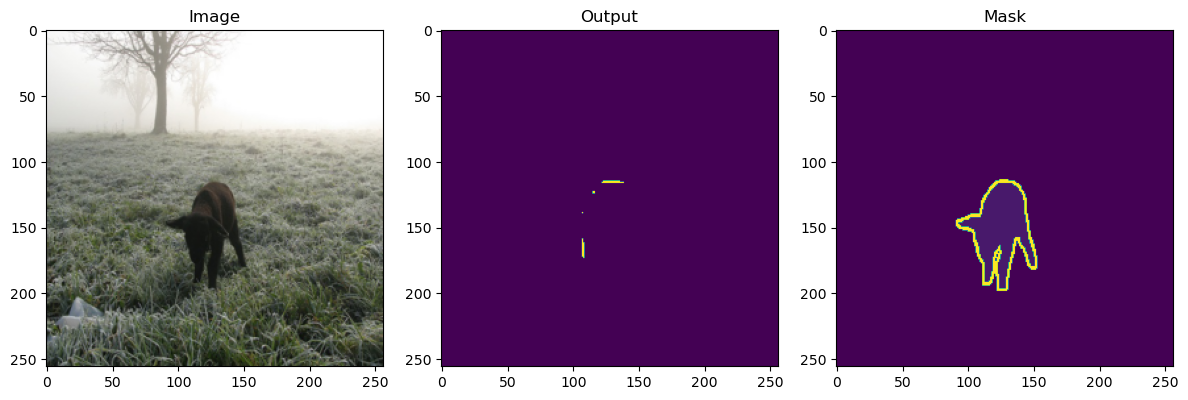

In [123]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load and visualize the saved images, outputs, and masks for a specific index
index = 125

# Load the image, output, and mask tensors
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/test/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

# Convert the image, output, and mask tensors to NumPy arrays
image_np = image.squeeze().permute(1, 2, 0).numpy()
output_np = output.squeeze().argmax(dim=0).numpy()
mask_np = mask.squeeze().numpy()

# Plot the image, output, and mask
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(image_np)
axs[0].set_title('Image')
axs[1].imshow(output_np)
axs[1].set_title('Output')
axs[2].imshow(mask_np)
axs[2].set_title('Mask')

plt.tight_layout()
plt.show()

In [15]:
def train_parallel(progress_bar, batch_idx, images, masks, lock, device):
    """ Train the model in parallel. """
    
    # Move data to the device
    images = images.to(device)
    masks = masks.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)['out']

    # Calculate the loss
    loss = criterion(outputs, masks.squeeze(1).long())

    # Backward pass
    loss.backward()

    # Update the weights
    optimizer.step()

    # Accumulate the loss
    with lock:
        running_loss += loss.item()

    # Update the progress bar description
    progress_bar.set_postfix({"Loss": running_loss / (batch_idx + 1)})

In [17]:
# Create a lock object for synchronization
import torch.multiprocessing as mp
lock = mp.Lock()

In [20]:
# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0)
    for batch_idx, (images, masks) in progress_bar:
        # Create a process for parallel execution
        process = mp.Process(target=train_parallel, args=(progress_bar, batch_idx, images, masks, lock, device))
        process.start()
        process.join()

    # Print the average loss for the epoch
    average_loss.append(running_loss / len(train_loader))
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {average_loss[-1]}")

Epoch 1/10:   0%|          | 0/92 [10:29<?, ?it/s]


KeyboardInterrupt: 

## UNet

In [73]:
import torch
import torch.nn as nn
import torchvision.models as models

# pra resolver problema com certificado ssl
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = models.resnet18(pretrained=True)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create an instance of the U-Net model
in_channels = 3  # Number of input channels (e.g., RGB)
out_channels = 21  # Number of output channels (e.g., number of classes)
model = UNet(in_channels, out_channels)

# Set the model to evaluation mode
model.eval()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/tg/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

UNet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output from the encoder
        x = x.view(x.size(0), -1, 1, 1)  # Reshape to 4D tensor
        x = self.decoder(x)
        return x

# Create an instance of the U-Net model
in_channels = 3  # Number of input channels (e.g., RGB)
out_channels = 21  # Number of output channels (e.g., number of classes)
model = UNet(in_channels, out_channels)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        optimizer.zero_grad()

        # Reshape the input images
        batch_size, channels, height, width = images.size()
        images = images.view(batch_size, channels, height, width)

        outputs = model(images)
        loss = criterion(outputs, masks.long())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}")


Using cache found in /home/tg/.cache/torch/hub/pytorch_vision_v0.6.0


RuntimeError: Given transposed=1, weight of size [512, 256, 2, 2], expected input[8, 1000, 1, 1] to have 512 channels, but got 1000 channels instead

Split the dataset

In [58]:
split_dataset(dataset_dir, train_dir, val_dir, test_dir)

FileNotFoundError: [Errno 2] No such file or directory: '../data/pascal_voc_dataset/VOCdevkit/VOC2012/JPEGImages'

Train, validation, test split

In [24]:
import os
import random
from sklearn.model_selection import train_test_split

In [25]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [51]:
def split_dataset(dataset_dir, train_ratio, val_ratio, test_ratio, random_state=42):
    """ Split dataset into train, validation, and test sets. """
    # Get list of image files in the dataset directory
    image_files = [file for file in os.listdir(dataset_dir) if file.endswith(".jpg")]
    mask_files = [file for file in os.listdir(mask_dir) if file.endswith(".png")]
    
    # Split the dataset into train, validation, and test sets
    train_files, remaining_files = train_test_split(image_files, test_size=(val_ratio + test_ratio), random_state=random_state)
    val_files, test_files = train_test_split(remaining_files, test_size=test_ratio/(val_ratio + test_ratio), random_state=random_state)

    return train_files, val_files, test_files, mask_files

# Paths and directories
dataset_dir = "../data/pascal_voc_dataset/VOCdevkit/VOC2012/JPEGImages"

# Split the dataset
train_files, val_files, test_files, mask_files = split_dataset(dataset_dir, train_ratio, val_ratio, test_ratio)

print("Train files:", len(train_files))
print("Test files:", len(test_files))
print("Validation files:", len(val_files))
print("Mask files:", len(mask_files))

Train files: 11987
Test files: 2569
Validation files: 2569
Mask files: 2913


In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define transformations for the masks
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Download and load the PASCAL VOC dataset with image and mask transformations
train_set = VOCSegmentation(root='/path/to/dataset', year='2012', image_set='train', download=True, transform=transform, target_transform=mask_transform)
val_set = VOCSegmentation(root='/path/to/dataset', year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = VOCSegmentation(root='/path/to/dataset', year='2012', image_set='test', download=True, transform=transform, target_transform=mask_transform)

# Split the dataset into training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)


### Transforming the dataset

In [26]:
import torch
from torchvision import transforms
from PIL import Image

Load the images and masks

In [27]:
def load_image(file_path):
    image = Image.open(file_path).convert("RGB")
    return image

def load_mask(file_path):
    mask = Image.open(file_path).convert("L")
    return mask

Resize the images and masks

In [28]:
def resize_image(image, target_size):
    resize = transforms.Resize(target_size)
    resized_image = resize(image)
    return resized_image

def resize_mask(mask, target_size):
    resize = transforms.Resize(target_size)
    resized_mask = resize(mask)
    return resized_mask

Convert images and masks to Tensor

In [29]:
def convert_image_to_tensor(image):
    transform = transforms.ToTensor()
    image_tensor = transform(image)
    return image_tensor

def convert_mask_to_tensor(mask):
    transform = transforms.ToTensor()
    mask_tensor = transform(mask)
    return mask_tensor

Normalize the image data

In [30]:
def normalize_image(image_tensor):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    normalized_image = normalize(image_tensor)
    return normalized_image

Preprocess data for training

In [31]:
def preprocess_data(image_path, mask_path, target_size):
    # Load
    image = load_image(image_path)
    mask = load_mask(mask_path)

    # Resize
    image = resize_image(image, target_size)
    mask = resize_mask(mask, target_size)

    # Convert
    image_tensor = convert_image_to_tensor(image)
    mask_tensor = convert_mask_to_tensor(mask)

    # Normalize
    normalized_image = normalize_image(image_tensor)

    return normalized_image, mask_tensor

Preproccess dataset

In [84]:
in_channels = 3  # RGB
out_channels = 1  # mask

In [85]:
model = UNet(in_channels, out_channels)
model

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder1): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder2): Sequential(
    (0): Conv2d(67, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
)